In [41]:
import numpy as np
import torch
import dgl
from torch import nn


def get_complete_edges(g):
    """List complete edges of a dgl graph"""
    def leading_zero(x):
        yield torch.zeros_like(x[0])
        yield from x
    x = torch.cumsum(g.batch_num_nodes(), 0)
    all_edges = []
    for a, b in zip(leading_zero(x), x):
        edges = torch.combinations(torch.arange(a, b))
        all_edges.append(edges)
    return torch.cat(all_edges, 0).T

def add_complete_edges(g):
    n1 = g.number_of_nodes()
    edges = get_complete_edges(g)
    g.add_edges(edges[0], edges[1])
    g.add_edges(edges[1], edges[0])
    n2 = g.number_of_nodes()
    assert n1 == n2
    return g

In [3]:
import pandas as pd

df = pd.read_csv('lucas0_train.csv')
df.head()

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


In [32]:
causes = list(df.columns[:-1])
causes.sort()

cause_to_idx = {c: i for i, c in enumerate(causes)}
cause_to_idx

{'Allergy': 0,
 'Anxiety': 1,
 'Attention_Disorder': 2,
 'Born_an_Even_Day': 3,
 'Car_Accident': 4,
 'Coughing': 5,
 'Fatigue': 6,
 'Genetics': 7,
 'Peer_Pressure': 8,
 'Smoking': 9,
 'Yellow_Fingers': 10}

In [51]:
causes = list(df.columns)
causes.sort()

cause_to_idx = {c: i for i, c in enumerate(causes)}
cause_to_idx

for _, row in df.iterrows():
    ...
    

g = dgl.graph(([], []))
g.add_nodes(len(row))
g.ndata['x'] = torch.arange(len(row)).unsqueeze(1)
g.ndata['y'] = torch.tensor(row).unsqueeze(1)


g.ndata

{'x': tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11]]), 'y': tensor([[1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1]])}

In [162]:
g = dgl.graph(([0], [2]))


g.ndata['global_x'] = torch.zeros(1, 4).expand((g.number_of_nodes(), -1))
g.ndata['global_x'][:1]

tensor([[0., 0., 0., 0.]])

In [152]:
torch.cat([torch.zeros(3, 4), torch.zeros(3, 4)], 0)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [247]:
from torch import distributions as dist

dist.Bernoulli(0.5).sample((1, 3))

tensor([[1., 1., 0.]])

# TODO: maybe don't just use a mask, but use a different graph structure to predict?

In [480]:
from torch.utils.data import DataLoader, Dataset


class LungCancerDataset(Dataset):
    
    def __init__(self, df):
        self.df = df
        self.acquired = {}
        
    def __getitem__(self, i):
        if i not in self.acquired:
            
            row = df.iloc[i]
            g = dgl.graph(([], []))
            g.add_nodes(len(row))
            g.ndata['x'] = torch.arange(len(row)).unsqueeze(1)
            g.ndata['y'] = torch.tensor(row).unsqueeze(1)
            g.ndata['mask'] = torch.ones(len(row))
            g.ndata['mask'][torch.randint(0, 12, (1,))] = 0
#             g.ndata['mask'] = dist.Bernoulli(0.95).sample(g.ndata['x'].shape)
            g.ndata['y_hat'] = g.ndata['y'].clone()
            g.ndata['y'][~g.ndata['mask'].bool()] = -1
            add_complete_edges(g)
            self.acquired[i] = g
            return g
        else:
            return self.acquired[i]
    
    def __len__(self):
        return len(self.df)

In [481]:
from abc import ABC, abstractmethod
from torch import nn
from typing import *
import torch
from copy import deepcopy
import matplotlib as mpl
from matplotlib import cm
from dgl import ops as Fops


def clones(net, N):
    return [deepcopy(net) for _ in range(N)]
    
    
class SizedModule(ABC) :

    @abstractmethod
    def get_size(self) -> int:
        ...
                  
class AddNorm(nn.Module):
    
    def __init__(self, size: Optional[int] = None, dropout: float = 0.1, layer: Optional[SizedModule] = None):
        super().__init__()
        if size is None and layer is None:
            return ValueError("Either size or layer must be provided")
        self.size = size or layer.get_size()
        self.layer = layer
        self.norm = nn.LayerNorm(self.size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, args=None, kwargs=None, layer: Optional[SizedModule] = None):
        kwargs = kwargs or dict()
        if args is None:
            args = (x,)
        layer = layer or self.layer
        return self.norm(x + self.dropout(layer(*args, **kwargs)))
    

    
class MultiHeadAttention(nn.Module):
    
    def __init__(self, dim_model, h):
        super().__init__()
        assert dim_model % h == 0
        self.h = h
        self.dim_model = dim_model
        self.d_k = dim_model // h
        self.linears  = clones(nn.Linear(dim_model, dim_model), 4)
        self.attn = None
    
    def _view_head(self, x):
        return x.view(x.size(0), -1, self.h, self.d_k).transpose(1, 2)
        
    def forward(self, g, query, key, value):
        q = self._view_head(self.linears[0](query))
        k = self._view_head(self.linears[1](key))
        v = self._view_head(self.linears[2](value))
        score = Fops.edge_softmax(g, Fops.v_dot_u(g, q, k) / self.d_k**0.5)
#         score = Fops.v_dot_u(g, q, k) / self.d_k**0.5
#         score = F.leaky_relu(Fops.v_dot_u(g, q, k) / self.d_k**0.5)
        out = Fops.u_mul_e_sum(g, v, score)
        out = out.transpose(1, 2).view(g.number_of_nodes(), self.h * self.d_k)
        score = score.view(score.size(0), self.h, -1)
        self.attn = score
        out = self.linears[3](out)
        return out
    

class Network(nn.Module):
    
    def __init__(self, d_model, h=16, n_heads=4, dropout=0.2):
        super().__init__()
        self.src_embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.dst_embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.encode = nn.Sequential(
            nn.Linear(1, h),
            nn.LeakyReLU(),
        )
        self.attn = AddNorm(h, layer=MultiHeadAttention(h, n_heads), dropout=dropout)
        self.core = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
        )
        self.decode = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, 1)
        )
            
        
    def forward(self, g, n_loops=5):
        with g.local_scope():
            g.ndata['a'] = self.src_embedding(g.ndata['x'].flatten().long())
            g.ndata['b'] = self.dst_embedding(g.ndata['x'].flatten().long())
            g.ndata['h'] = self.encode(g.ndata['y'].float())
            out_arr = []
            for i in range(n_loops):
                g.ndata['h'] = self.attn(g.ndata['h'], args=(g, g.ndata['a'], g.ndata['b'], g.ndata['h']))
                g.ndata['h'] = self.core(g.ndata['h'])
                out = nn.Sigmoid()(self.decode(g.ndata['h']))
                out_arr.append(out)
            
            return out_arr
        
net = Network(32)


dataset = LungCancerDataset(df.iloc[:-1000])
loader = DataLoader(dataset, batch_size=32, collate_fn=dgl.batch, shuffle=True)
for x in loader:
    ...
m = x.ndata['mask'].bool()
# set out to predict each node in the graph as apposed to just predicting lung cancer
# we are not making any assumptions that lung_cancer is the target which we seek to understand
# rather, we try to learn the entire causal graph
net(x)[-1][~m].shape

torch.Size([8, 1])

In [539]:
from tqdm.auto import tqdm
from IPython import display
from matplotlib import pylab as plt

net = Network(d_model=len(df.columns), h=128, n_heads=8, dropout=0.2)

dataset = LungCancerDataset(df.iloc[:-1000])
loader = DataLoader(dataset, batch_size=256, collate_fn=dgl.batch, shuffle=True)

eval_dataset = LungCancerDataset(df.iloc[-1000:])
eval_loader = DataLoader(dataset, batch_size=len(eval_dataset), collate_fn=dgl.batch, shuffle=False)

optim = torch.optim.AdamW(net.parameters(), lr=1e-3)
lossfn = torch.nn.BCELoss()
losses = []

def evaluate():
    total_loss = 0
    for g in eval_loader:
        net.eval()
        with torch.no_grad():
            m = g.ndata['mask'].bool()
            y_arr = net(g)[:]
            
            y_hat = g.ndata['y_hat'][~m].float()
            loss = torch.tensor(0.)
            for y in y_arr:
                loss += lossfn(y[~m], y_hat.float())
            
            total_loss+=loss.detach().item()
    return total_loss

eval_losses = []
for epoch in tqdm(range(1000)):
    for g in loader:
        m = g.ndata['mask'].bool()
        y_arr = net(g)[-1:]
        y_hat = g.ndata['y_hat'][~m].float()
        loss = torch.tensor(0.)
        for y in y_arr:
            loss += lossfn(y[~m], y_hat.float())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.detach().item())
        display.clear_output(wait=True)
        plt.plot(losses)
        plt.show()
        
#         display.clear_output(wait=True)
#         plt.plot(eval_losses)
#         plt.show()
        
    if epoch % 1 == 0:
        eval_loss = evaluate()
        eval_losses.append(eval_loss)
        
        

        

KeyboardInterrupt: 

Index(['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer'],
      dtype='object')


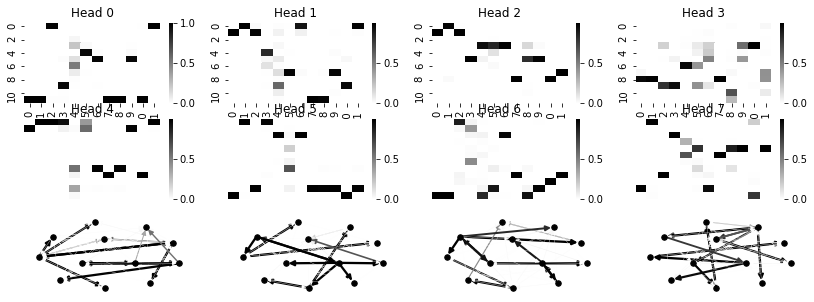

(12, 12)


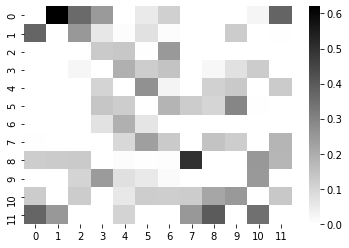

In [551]:
import seaborn as sns

def to_nxg(g: dgl.DGLGraph) -> nx.DiGraph:
    nxg = nx.DiGraph(g.to_networkx())
    return nxg
    
def plot_graph(g: dgl.DGLGraph, ax=None, prog='neato', **kwargs):
    nxg = to_nxg(g)
    pos = nx.nx_agraph.pygraphviz_layout(nxg, prog=prog)
    nx.draw(nxg, pos=pos, ax=ax, **kwargs)
    return ax, pos, nxg

def attn_to_sparse(g: dgl.DGLGraph, attn: torch.Tensor):
    n = g.number_of_nodes()
    i = torch.stack(g.edges())
    v = attn
    x = torch.sparse_coo_tensor(i, v.flatten(), (n, n))
    return x


def plot_multihead_attention(g, attn, cmap='binary', node_color='k', node_size=30, prog='neato', scale_width=2., min_width=0.3):
    fig, axes = plt.subplots(3, 4, figsize=(14, 5))
    attn_arr =[]
    for i in range(attn.size(1)):
        ax = axes.flatten()[i]
        ax.set_title("Head {}".format(i))
        a = attn[:, i].detach().flatten()
        _attn = attn_to_sparse(g, a).to_dense().numpy()
        attn_arr.append(_attn)
        sns.heatmap(_attn, ax=ax, linewidths=0, cmap=cmap)
        norm = mpl.colors.Normalize(vmin=0,vmax=1.)
        edge_colors = cm.get_cmap(cmap)(norm(a))
        edges = g.edges()
        edgelist = [(edges[0][i].item(), edges[1][i].item()) for i in range(g.number_of_edges())]
        
        ax, pos, nxg = plot_graph(g, prog=prog, width=a*scale_width + min_width, edge_color=edge_colors, edgelist=edgelist, ax=axes.flatten()[i+4], node_size=node_size, node_color=node_color)
#         nx.draw_networkx_labels(g, ax=ax, pos=pos, labels={v: v for v in list(range(g.number_of_nodes()))})
    plt.show()
    avg = np.stack(attn_arr).mean(0)
    print(avg.shape)
    sns.heatmap(avg, linewidths=0, cmap=cmap)
    return avg, attn_arr
g = eval_loader.dataset[0]
net(g)
net.attn.layer.attn.shape

print(df.columns)
a, arr = plot_multihead_attention(g, net.attn.layer.attn)


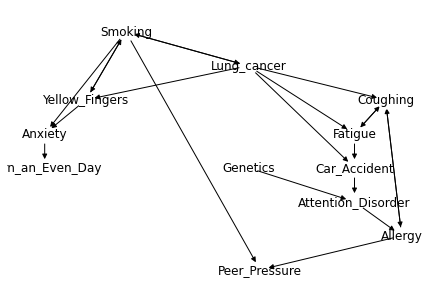

In [571]:
a = np.stack(arr).mean(0)
x = a.flatten()

idx = np.argwhere(x > 0.2).flatten()

edges = np.unravel_index(idx, (12, 12))

nxg = nx.DiGraph()

for n1, n2 in zip(*edges):
    node1 = df.columns[n1]
    node2 = df.columns[n2]
    val = a[n1, n2]
    nxg.add_node(n1, name=node1)
    nxg.add_node(n2, name=node2)
    nxg.add_edge(n1, n2, val=val)
    

pos = nx.nx_agraph.pygraphviz_layout(nxg, prog='dot')
labels = {n: ndata['name'] for n, ndata in nxg.nodes(data=True)}
nx.draw(nxg, pos=pos, labels=labels, node_size=300, node_color='w', width=1)

In [505]:
nx.draw_networkx_labels?

Signature:
nx.draw_networkx_labels(
    G,
    pos,
    labels=None,
    font_size=12,
    font_color='k',
    font_family='sans-serif',
    font_weight='normal',
    alpha=None,
    bbox=None,
    horizontalalignment='center',
    verticalalignment='center',
    ax=None,
)
Docstring:
Draw node labels on the graph G.

Parameters
----------
G : graph
   A networkx graph

pos : dictionary
   A dictionary with nodes as keys and positions as values.
   Positions should be sequences of length 2.

labels : dictionary, optional (default=None)
   Node labels in a dictionary keyed by node of text labels
   Node-keys in labels should appear as keys in `pos`.
   If needed use: `{n:lab for n,lab in labels.items() if n in pos}`

font_size : int
   Font size for text labels (default=12)

font_color : string
   Font color string (default='k' black)

font_family : string
   Font family (default='sans-serif')

font_weight : string
   Font weight (default='normal')

alpha : float or None
   The text tra

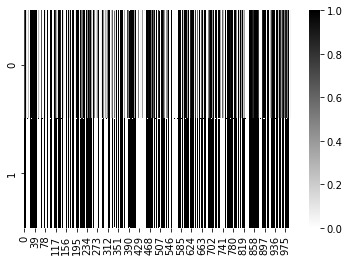

In [485]:

total_loss = 0
for g in eval_loader:
    net.eval()
    with torch.no_grad():
        m = g.ndata['mask'].bool()
        y = net(g)[-1][~m]
        y_hat = g.ndata['y_hat'][~m].float()
        
        x = torch.stack([y, y_hat]).squeeze(-1)
        sns.heatmap(x.detach().numpy(), cmap='binary')

In [317]:
total_loss = 0
for g in eval_loader:
    net.eval()
    with torch.no_grad():
        m = g.ndata['mask'].bool()
        y = net(g)[~m]
        y_hat = g.ndata['y'][~m].float()
        loss = lossfn(y, y_hat.float())
        total_loss+=loss.detach().item()
print(total_loss)

0.6409891247749329
